In [1]:
# Imports 
# native
import os
import re
from collections import Counter
from collections import defaultdict
import random
from itertools import chain

# external
import requests
import numpy as np
import seaborn as sns
import modin.pandas as pd
from modin.config import Engine
Engine.put("ray")
os.environ["MODIN_CPUS"] = "3"


In [2]:
# Functions 
def count_seeds_from_tsv(tsv_file_path: str):
    counter = Counter()
    with open(tsv_file_path, 'r') as f:
        for record in f:
            seed, member = record.strip().split('\t')
            counter[seed] += 1
    return { 'seeds' : len(counter.keys()), 'proteins' : sum(counter.values()) }

# def count_homologues_in_each_seed(tsv_file_path: str):
#     counter = Counter()
#     with open(tsv_file_path, 'r') as f:
#         for record in f:
#             seed, member = record.strip().split('\t')
#             counter[seed] += 1
#     return tuple(counter.values())

def parse_mmseqs_seeds(seeds_tsv_file):
    """ 
    mmseqs2 tsv files are usually very big
    the idea here is to create a generator
    that will only read and yield a cluster
    at a time so my crappy pc can parse all
    data in chunks.
    For this to work the tsv mmseqs needs to be
    sorted by the first column.
    """
    
    format_df = lambda current_seed, members: pd.DataFrame(zip(repeat(current_seed), members), columns=('seeds', 'members'))
    
    with open(seeds_tsv_file) as f:
        
        current_seed = None
        members = []
                
        for record in f:
            seed, member = record.strip().split('\t')
            
            if current_seed and seed != current_seed:
                
                yield (current_seed, format_df(current_seed, members))
                
                current_seed = None
                members = []
                
            if not current_seed:
                current_seed = seed
                
            members.append(member)
            
        yield (current_seed, format_df(current_seed, members))
            

# Trying the icity approuch 
Let's try the [icity method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6003329/), this approuch consists on finding a set of baits (interest _loci_) and then trought the use of a few scoring functions (mainly icity) find nighboorhood genes that might have functional relationships.

## Clustering all _Salmonella_ proteins
All _Salmonella_ proteins annotated with prokka where merged in one file and clustered with mmseqs2 with min coverage (-c 0.9) and min identity (-min-ind-pct 0.9). The barplot bellow show the count of all proteins in the _Salmonella_ genomes and the count of seeds (clusters) after mmseqs2 clustering.

In [20]:
clustered_proteins_file = '/home/hugo/projects/salmonella-bacterial-immunity/clu_90_90.sorted.tsv'

seeds_and_proteins_count = count_seeds_from_tsv(clustered_proteins_file)
seeds_and_proteins_count

{'seeds': 264793, 'proteins': 74326142}

Text(0.5, 0.98, 'Count of seeds after mmseqs2 clustering')

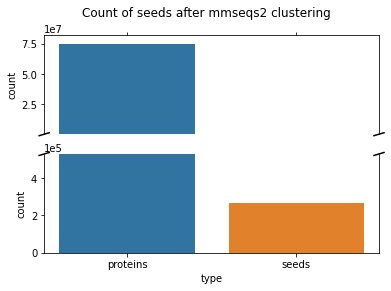

In [62]:
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/broken_axis.html

temp = pd.DataFrame(seeds_and_proteins_count.items(), columns=('type', 'count')).sort_values('count', ascending=False)

# create a 2 by 1 grid 
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# Create two plots (top and bottom)
sns.barplot(x='type', y='count', data=temp, ax=ax)
sns.barplot(x='type', y='count', data=temp, ax=ax2)

# Set sci notation to y
ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
# Set limit to top and bottom
bottom_limit = temp['count'].min() * 2
top_limit = temp['count'].max() * 1.1
ax.set_ylim(bottom_limit, top_limit)  # outliers only
ax2.set_ylim(0, bottom_limit)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax.set_xlabel('') # remove top xlabel

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Set title 
f.suptitle("Count of seeds after mmseqs2 clustering")

Before doing clustering we had approximately 74 million single proteins in all the 16,5 thousand genomes of _Salmonella_. This was reduced to 250 thousand seeds (clusters) after the mmseqs clustering. 

## Filtering out seeds that don't have defesense systems as neighbors

The idea of doing the clustering is to established relationships between the proteins on the genomes. So here we are going to drop seeds that don't at least single homologus members that is a neighbor of a defesense system gene. 

In [9]:
seeds_mmseqs = '/home/hugo/projects/salmonella-bacterial-immunity/clu_90_90.sorted.tsv'
locus_tags_in_the_extracted_cassettes_file = '/home/hugo/projects/salmonella-bacterial-immunity/net_data_16K/neighborhood_baits_locus_tags.txt'
locus_tags_in_the_extracted_cassettes = set([
    record.strip()
    for record in open(locus_tags_in_the_extracted_cassettes_file, 'r')
])

In [ ]:
with open(seeds_mmseqs) as f:
    interest_seeds = Counter()
    not_interest_seeds = Counter()
    for record in f:
        seed, member = record.strip().split('\t')
        if member in locus_tags_in_the_extracted_cassettes:
            interest_seeds[seed] += 1
            continue
        not_interest_seeds[seed] += 1

In [23]:
clusters_with_defesense_systems = set(interest_seeds.keys())

In [37]:
with open('/home/hugo/projects/salmonella-bacterial-immunity/seeds_neighborhood_all_locus_tags.txt', 'w') as f_out:
    with open(seeds_mmseqs) as f_in:
        for record in f_in:
            seed, member = record.strip().split('\t')
            if seed in clusters_with_defesense_systems:
                f_out.write(record)
                

In [3]:
# reading the clusters with defesen system prediction
all_cds_prokka_with_dfs_file = '../../all_cds_prokka_with_dfs_df.sample.tsv'
seeds_with_dfs_neighborhood_file = '/home/hugo/projects/salmonella-bacterial-immunity/seeds_neighborhood_all_locus_tags.txt'

prokka_annotation_with_dfs_prediction_df = (pd.read_csv(all_cds_prokka_with_dfs_file, sep='\t', header=None)
      .rename(columns=dict(zip(range(7), ['contig_id', 'locus_tag', 'start', 'end', 'strand', 'info', 'dfs_prediction'])))
     )

prokka_annotation_with_dfs_prediction_df.head()

,contig_id,locus_tag,start,end,strand,info,dfs_prediction
0,590.14554_15,GHMJFKBF_04077,19602,20129,-,ID=GHMJFKBF_04077;Name=smpB;db_xref=COG:COG069...,NaN
1,28901.6398_9,EIGKBAPH_01894,1370,2371,-,ID=EIGKBAPH_01894;Name=flk;gene=flk;inference=...,NaN
2,590.16778_1,APLOOEAI_00237,250311,250838,+,ID=APLOOEAI_00237;inference=ab initio predicti...,NaN
3,590.12415_3,EOJOGDAB_01420,443355,444233,-,ID=EOJOGDAB_01420;inference=ab initio predicti...,NaN
4,28901.7569_18,IOBCOIAP_04123,2496,3191,-,ID=IOBCOIAP_04123;Name=napG;db_xref=COG:COG114...,NaN


In [4]:
prokka_annotation_with_dfs_prediction_df = (prokka_annotation_with_dfs_prediction_df.merge(
                                                pd.read_csv(seeds_with_dfs_neighborhood_file, header=None, sep='\t').rename(columns=dict(zip(range(2), ['seeds', 'members']))),
                                                left_on=['locus_tag'],
                                                right_on=['members'],
                                                how='left')
                                            .drop('members', axis=1)
                                            .assign(contig = lambda df: df.contig_id.apply(lambda x: x.split('_')[0]))
                                            .assign(contig_order = lambda df: df.contig_id.apply(lambda x: int(x.split('_')[1])))
                                            .sort_values(['contig', 'contig_order', 'start', 'end'])
                                            .drop(['contig', 'contig_order'], axis=1)
                                            .merge(
                                                (pd.read_csv('/home/hugo/projects/salmonella-bacterial-immunity/net_data_16K/mmseqs_cluster.tsv.gz', sep='\t', header=None)[1]
                                                    .str.split(':', expand=True)
                                                    .iloc[:,[1,4]]
                                                    .sort_values(4)
                                                    .rename(columns={ 1 :'casset_id', 4 :'locus_tag'})),
                                                on=['locus_tag'],
                                                how='left'
                                            )
                                           )

# ICITY = .assign(icity = lambda df: df.casset_id.dropna().shape[0]/df.casset_id.shape[0])
prokka_annotation_with_dfs_prediction_df.head()

,contig_id,locus_tag,start,end,strand,info,dfs_prediction,seeds,casset_id
0,1003185.3_1,EGCDDHHA_00070,72141,72863,-,ID=EGCDDHHA_00070;inference=ab initio predicti...,NaN,JBJJJIHD_00921,NaN
1,1003185.3_10,EGCDDHHA_00481,82119,83759,+,ID=EGCDDHHA_00481;Name=pqiB;db_xref=COG:COG300...,NaN,LLDDHGNM_03481,NaN
2,1003185.3_11,EGCDDHHA_00577,38768,39529,-,ID=EGCDDHHA_00577;inference=ab initio predicti...,NaN,NEMLBJNO_02300,NaN
3,1003185.3_11,EGCDDHHA_00586,52312,52521,+,ID=EGCDDHHA_00586;inference=ab initio predicti...,NaN,HMFKIHPF_02547,NaN
4,1003185.3_19,EGCDDHHA_01014,64759,65169,-,ID=EGCDDHHA_01014;Name=hslJ;db_xref=COG:COG318...,NaN,JFCHOBKH_04755,NaN


In [111]:
# %%time
def get_bait_distances(main_df):
    temp = []
    for i, df in main_df.query('casset_id.notna()').groupby(['contig_id', 'casset_id']):
        try:
            if i[0] == '2052597.6_10':
                temp.append(df.assign(closest_bait_distance = lambda df: df.start.apply(lambda query_start: min(map(
                     lambda bait_start: abs(query_start - bait_start),
                     df.query('dfs_prediction == dfs_prediction').start.values.tolist()
                )))))
        except:
            pass
    return pd.concat(
        map(
            lambda gdf: pd.DataFrame(
                data=[(gdf[0], gdf[1].closest_bait_distance.mean(),  gdf[1].closest_bait_distance.std(), gdf[1].closest_bait_distance.std()/gdf[1].closest_bait_distance.mean())],
                columns=('seeds', 'mean_closest_bait_distance', 'std_closest_bait_distance', 'cv_closest_bait_distance')
            ),
            pd.concat(temp)[['seeds', 'closest_bait_distance']].groupby('seeds')
        )
    )

test = get_bait_distances(prokka_annotation_with_dfs_prediction_df)
test.head()

,seeds,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance
0,BCJMLKNI_02488,11278.0,NaN,NaN
0,DBIGANNC_02835,0.0,NaN,NaN
0,KALCACID_02893,14265.0,NaN,NaN
0,KCMIJPJB_03443,7066.0,NaN,NaN


In [218]:
def get_percentage_of_member_count(df):
    results = []
    for total, count_dict in df.loc[:,['members_count', 'members_names']].values.tolist():
        record = []
        for name, count in count_dict.items():
            record.append('{}:{}%'.format(name, round((count/total) * 100, 2)))
        results.append(','.join(record))
    return results



(prokka_annotation_with_dfs_prediction_df.sample(12)
 .loc[:,['seeds']]
 .drop_duplicates()
 .reset_index(drop=True)
 .assign(members_count = lambda df: df.seeds.apply(lambda seed: prokka_annotation_with_dfs_prediction_df.query('seeds == @seed').shape[0]))
 .assign(members_names = lambda df: df.seeds.apply(
     lambda seed: Counter(prokka_annotation_with_dfs_prediction_df.query('seeds == @seed')['info'].apply(
         lambda info: dict(map(lambda x: x.split('='), info.split(';'))).get('Name', 'Hypothetical Protein')
     ).values.tolist())
  ))
 .assign(members_names = lambda df: get_percentage_of_member_count(df))
 .assign(icity = lambda df: df.seeds.apply(
     lambda seed: prokka_annotation_with_dfs_prediction_df.query('seeds == @seed').assign(icity = lambda df1: df1.casset_id.dropna().shape[0]/df1.casset_id.shape[0]).icity.values.tolist()[0]
 ))
 .assign(members_close_to_baits = lambda df: df.seeds.apply(
     lambda seed: prokka_annotation_with_dfs_prediction_df.query('seeds == @seed').casset_id.dropna().shape[0]
 ))
 .merge(
     get_bait_distances(prokka_annotation_with_dfs_prediction_df),
     on='seeds',
     how='left'
 )
 .assign(diversity_of_close_systems = lambda df: df.seeds.apply(lambda seed: Counter(prokka_annotation_with_dfs_prediction_df.query('seeds == @seed and casset_id.notna()')[['contig_id', 'casset_id']]
                                                                            .merge(
                                                                                prokka_annotation_with_dfs_prediction_df.query('casset_id.notna()')[['contig_id','casset_id', 'dfs_prediction']].dropna(),
                                                                                on=['contig_id','casset_id'],
                                                                                how='inner').dfs_prediction.values.tolist())))
 .assign(diversity_score = lambda df: df.diversity_of_close_systems.apply(lambda x: sum(x.values())))
 .assign(all_dfs = prokka_annotation_with_dfs_prediction_df.dfs_prediction.dropna().shape[0])
 .assign(diversity_score = lambda df: tuple(map(lambda tup: tup[0]/tup[1], zip(df.diversity_score.values.tolist(), df.all_dfs.values.tolist()))))
 .assign(diversity_of_close_systems = lambda df: df.diversity_of_close_systems.apply(lambda x: str(dict(x))).replace('{}', np.nan))
 .drop('all_dfs', axis=1)
 .head(12)
)
# .assign(diversity_score = lambda df: tuple(map(lambda tup: tup[0]/tup[1], zip(df.diversity_score.values.tolist(), df.all_dfs.values.tolist()))))

,seeds,members_count,members_names,icity,members_close_to_baits,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance,diversity_of_close_systems,diversity_score
0,IJGMDOHE_00727,128,cbiM:100.0%,0.007812,1,NaN,NaN,NaN,NaN,0.000000
1,PDLODOLG_04079,166,tolB:100.0%,0.000000,0,NaN,NaN,NaN,NaN,0.000000
2,KNPMLPFD_03370,147,yjjP:100.0%,0.000000,0,NaN,NaN,NaN,NaN,0.000000
3,AHDJACDG_03207,152,Hypothetical Protein:100.0%,1.000000,152,NaN,NaN,NaN,"{'padloc:name=MTase_III,system=DMS_other;defen...",0.038031
4,FMPPFLAJ_01632,182,"yhaJ_1:52.75%,yhaJ_2:46.15%,yhaJ:1.1%",0.000000,0,NaN,NaN,NaN,NaN,0.000000
5,HANIIMJN_00747,177,"dnaC:50.85%,dnaC_1:37.85%,dnaC_2:10.73%,dnaC_3...",0.135593,24,NaN,NaN,NaN,"{'padloc:name=MTase_I,system=DMS_other;defense...",0.000249
6,KFOIKKHF_02317,144,"cysH_2:41.67%,cysH_1:56.94%,cysH:1.39%",0.861111,124,NaN,NaN,NaN,"{'padloc:name=Cas8e,system=cas_type_I-E;defens...",0.001989
7,MMNBGFDD_03290,167,"prfB_2:47.31%,prfB_1:50.9%,prfA_1:0.6%,prfB_3:...",0.035928,6,NaN,NaN,NaN,NaN,0.000000
8,BKCCDIPE_00552,172,aroQ:100.0%,0.000000,0,NaN,NaN,NaN,NaN,0.000000
9,ONMBJOCA_01516,159,mazG:100.0%,0.672956,107,NaN,NaN,NaN,"{'padloc:name=Cas8e,system=cas_type_I-E;defens...",0.002237


In [90]:
test.query('contig_id == "2052597.6_10"').head()

,contig_id,locus_tag,start,end,strand,info,dfs_prediction,seeds,casset_id,closest_bait_distance


In [43]:
(df.groupby('seeds', as_index=False)
 .apply(lambda df: (
     df.assign(mean_closest_bait_distance = df.closest_bait_distance.mean())
     .assign(std_closest_bait_distance = df.closest_bait_distance.std())
     .assign(cv_closest_bait_distance = df.closest_bait_distance.std() / df.closest_bait_distance.mean())
     .drop_duplicates()
 ))
)

,seeds,closest_bait_distance,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance
27507,BCJMLKNI_02488,11278,11278.0,NaN,NaN
27508,KCMIJPJB_03443,7066,7066.0,NaN,NaN
27509,DBIGANNC_02835,0,0.0,NaN,NaN
27510,KALCACID_02893,14265,14265.0,NaN,NaN


In [124]:
df.assign(closest_bait_distance = lambda df: df.start.apply(lambda query_start: min(map(
         lambda bait_start: abs(query_start - bait_start),
         df.query('dfs_prediction == dfs_prediction').start.values.tolist()
    )))
 )


,contig_id,locus_tag,start,end,strand,info,dfs_prediction,seeds,casset_id,closest_bait_distance
27507,2052597.6_10,BHKANFOG_03246,34839,36110,-,ID=BHKANFOG_03246;inference=ab initio predicti...,NaN,BCJMLKNI_02488,Cassette_2,11278
27508,2052597.6_10,BHKANFOG_03249,39051,40421,+,ID=BHKANFOG_03249;eC_number=1.2.1.79;Name=gabD...,NaN,KCMIJPJB_03443,Cassette_2,7066
27509,2052597.6_10,BHKANFOG_03255,46117,47586,-,ID=BHKANFOG_03255;eC_number=2.1.1.72;db_xref=C...,"padloc:name=MTase_I,system=DMS_other;defensefi...",DBIGANNC_02835,Cassette_2,0
27510,2052597.6_10,BHKANFOG_03264,60382,60852,+,ID=BHKANFOG_03264;eC_number=2.7.1.-;inference=...,NaN,KALCACID_02893,Cassette_2,14265


In [44]:
df.mean_closest_bait_distance

,seeds,closest_bait_distance
27507,BCJMLKNI_02488,11278
27508,KCMIJPJB_03443,7066
27509,DBIGANNC_02835,0
27510,KALCACID_02893,14265


In [51]:
# prokka_annotation_with_dfs_prediction_df.query('casset_id.notna()').groupby(['contig_id', 'casset_id'], as_index=False)
#  .filter(lambda df: not df.query('contig_id == "2052597.6_10"').empty)
#  .groupby(['contig_id', 'casset_id'], as_index=False)
#  .apply(
#      lambda df: df.assign(
#          closest_bait_distance = lambda df: df.start.apply(lambda query_start: min(map(
#              lambda bait_start: abs(query_start - bait_start),
#              df.query('dfs_prediction.notna()').fillna(0).start.values.tolist()
#      )
boa = []                                                                     
for i, df in prokka_annotation_with_dfs_prediction_df.query('casset_id.notna()').groupby(['contig_id', 'casset_id'], as_index=False):
    try:
        df.assign(
                closest_bait_distance = lambda df: df.start.apply(lambda query_start: min(map(
                    lambda bait_start: abs(query_start - bait_start),
                    df.query('dfs_prediction.notna()').fillna(0).start.values.tolist()))))
        boa.append(i)
    except:
        pass


        contig_id       locus_tag  start   end strand  \
56  1003191.3_100  NMKNCAEP_01573   1088  1381      -   

                                                 info  \
56  ID=NMKNCAEP_01573;eC_number=3.1.-.-;Name=ygbF;...   

                                       dfs_prediction           seeds  \
56  padloc:name=Cas2e,system=cas_adaptation;defens...  LKNDCJAD_03675   

     casset_id  closest_bait_distance  
56  Cassette_1                      0  


In [186]:
 prokka_annotation_with_dfs_prediction_df.query('seeds == "KCMIJPJB_03443" and casset_id.notna()')[['seeds', 'contig_id', 'casset_id']].drop_duplicates()

,seeds,contig_id,casset_id
1603,KCMIJPJB_03443,108619.149_5,Cassette_1
4130,KCMIJPJB_03443,115981.101_18,Cassette_2
4315,KCMIJPJB_03443,115981.134_2,Cassette_2
7032,KCMIJPJB_03443,1182191.3_3,Cassette_2
8200,KCMIJPJB_03443,1242100.3_7,Cassette_2
...,...,...,...
247686,KCMIJPJB_03443,90371.3612_2,Cassette_1
249508,KCMIJPJB_03443,90371.3838_4,Cassette_1
252017,KCMIJPJB_03443,90371.4524_1,Cassette_2
253420,KCMIJPJB_03443,90371.923_5,Cassette_1


In [3]:
    pd.read_csv('/home/hugo/projects/salmonella-bacterial-immunity/AQUI_TEST.tsv', sep='\t').sort_values(['members_count', 'icity', 'mean_closest_bait_distance', 'diversity_score'], ascending=[False, True, False]).head()

,seeds,members_count,members_names,icity,members_close_to_baits,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance,diversity_of_close_systems,diversity_score
2705,DBIGANNC_02835,11,Hypothetical Protein:100.0%,1.0,11,0.0,NaN,NaN,"{'padloc:name=MTase_I,system=DMS_other;defense...",0.002486
3287,KALCACID_02893,1,Hypothetical Protein:100.0%,1.0,1,14265.0,NaN,NaN,"{'padloc:name=MTase_I,system=DMS_other;defense...",0.000249
1301,AHDJACDG_03207,152,Hypothetical Protein:100.0%,1.0,152,NaN,NaN,NaN,"{'padloc:name=MTase_III,system=DMS_other;defen...",0.038031
458,CPHHPHLB_05241,105,"casE:97.14%,cse3:1.9%,Hypothetical Protein:0.95%",1.0,105,NaN,NaN,NaN,"{'padloc:name=Cas6e,system=cas_type_I-E;defens...",0.028586
759,NBJKFGOO_02445,99,Hypothetical Protein:100.0%,1.0,99,NaN,NaN,NaN,"{'padloc:name=Cas3e,system=cas_type_I-E;defens...",0.028586


## Number of seeds after filtering 

In [10]:
icity_df = pd.read_csv('/home/hugo/projects/salmonella-bacterial-immunity/results/icity.main.tsv', sep='\t')[[
    'seeds',
    'members_names',
    'members_count',
    'members_close_to_baits',
    'icity', 'diversity_score',
    'diversity_of_close_systems',
    'mean_closest_bait_distance',
    'std_closest_bait_distance',
    'cv_closest_bait_distance'
]]
icity_df.head()

,seeds,members_names,members_count,members_close_to_baits,icity,diversity_score,diversity_of_close_systems,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance
0,ELEBACFE_01409,"apt:99.82%,apt_2:0.02%,apt_1:0.16%,apt_3:0.01%",16288,5,0.000307,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
1,GEPOOPDK_00969,"dnaX:99.96%,dnaX_1:0.03%,dnaX_2:0.01%,dnaX_3:0...",15988,5,0.000313,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
2,OPMEBHBH_00282,"ybaB:99.96%,ybaB_1:0.02%,ybaB_2:0.02%,ybaB_3:0...",16281,5,0.000307,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
3,LEDEBBBD_02850,"htpG_1:9.17%,htpG_2:1.62%,htpG:89.2%,htpG_3:0....",16253,5,0.000308,0.000012,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN
4,HLLNPLAH_02376,"adk:99.86%,adk_1:0.09%,adk_2:0.03%,adk_3:0.01%...",16284,1,0.000061,0.000002,"{'NA;defensefinder:name=Type_II_REases,system=...",NaN,NaN,NaN


In [14]:
before_filtering = {'seeds': 264793, 'proteins': 74326142,}

In [15]:
after_filtering = {'seeds': icity_df.seeds.shape[0], 'proteins': icity_df.members_count.sum()}

In [16]:
after_filtering

{'seeds': 20817, 'proteins': 25741130}

In [48]:
fig1_df = pd.DataFrame.from_dict({
    'status'  : ['before', 'before', 'after',  'after'],
    'count': [74326142, 264793, 25741130, 20817],
    'type'    : ['protein', 'seed', 'protein', 'seed'],
})
fig1_df.head()

,status,count,type
0,before,74326142,protein
1,before,264793,seed
2,after,25741130,protein
3,after,20817,seed


Text(0.5, 0.98, 'Fig1: Filter out seeds that dont have a single members close to a bait (some seeds are a bait)')

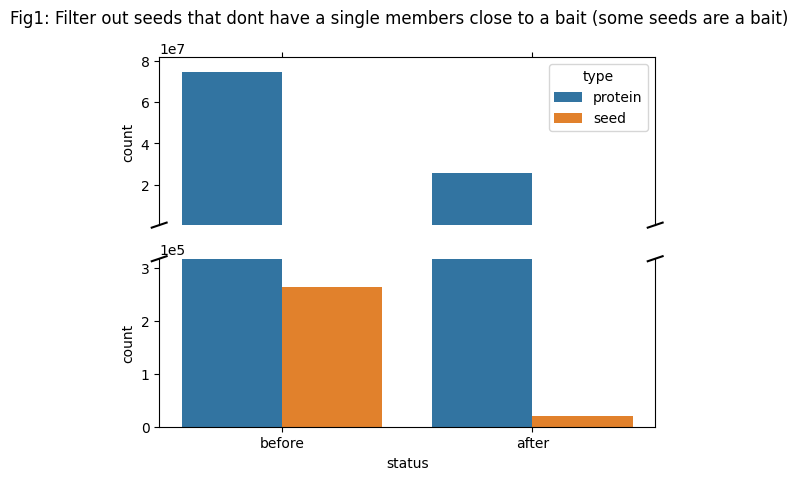

In [59]:
# create a 2 by 1 grid 
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# Create two plots (top and bottom)
sns.barplot(data=fig1_df, x='status', y='count', hue='type', ax=ax)
sns.barplot(data=fig1_df, x='status', y='count', hue='type', ax=ax2)
ax2.legend_.remove()

# Set sci notation to y
ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

# Set limit to top and bottom
bottom_limit = fig1_df.query('type == "seed"')['count'].max() * 1.2
top_limit = fig1_df['count'].max() * 1.1
ax.set_ylim(bottom_limit, top_limit)  # outliers only
ax2.set_ylim(0, bottom_limit)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax.set_xlabel('') # remove top xlabel

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Set title 
f.suptitle("Fig1: Filter out seeds that dont have a single members close to a bait (some seeds are a bait)")



 #, col='status' , kind='bar', aspect=.7)

<AxesSubplot:>

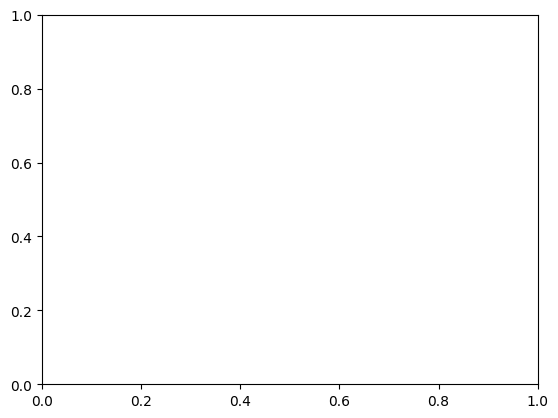

In [70]:
sns.histplot(x=icity_df.query('diversity_of_close_systems == "NA"').icity)

In [82]:
len(icity_df.diversity_of_close_systems.unique())

8153

In [91]:
icity_df.sort_values(['icity', 'diversity_score'], ascending=False).query('icity < 1').head(20)

,seeds,members_names,members_count,members_close_to_baits,icity,diversity_score,diversity_of_close_systems,mean_closest_bait_distance,std_closest_bait_distance,cv_closest_bait_distance
767,OIICPPNC_01267,"casC:99.85%,casC_1:0.08%,casC_2:0.07%",10120,10119,0.999901,0.199382,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
764,BPPBCHKB_01625,"ygbT:99.73%,ygbT_1:0.14%,ygbT_2:0.13%",9903,9902,0.999899,0.196177,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
766,NBJKFGOO_02445,Hypothetical Protein:100.0%,10234,10232,0.999805,0.201781,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
1814,IJLIHHGB_01195,"Hypothetical Protein:99.87%,casA:0.13%",4497,4496,0.999778,0.088684,"{'padloc:name=Cas5e,system=cas_type_I-E;defens...",NaN,NaN,NaN
768,LAGNHMEK_02052,Hypothetical Protein:100.0%,8589,8587,0.999767,0.168928,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
2180,ALDDAGCD_04218,Hypothetical Protein:100.0%,3982,3981,0.999749,0.076171,"{'NA;defensefinder:name=Mokosh_TypeII_MkoC,sys...",NaN,NaN,NaN
2181,FLEIADLP_00974,"lon_3:24.1%,lon_2:41.71%,lon_1:33.97%,lon_5:0....",3515,3514,0.999716,0.075385,"{'NA;defensefinder:name=Mokosh_TypeII_MkoC,sys...",NaN,NaN,NaN
2184,MIHNGDJK_00043,Hypothetical Protein:100.0%,3152,3151,0.999683,0.068916,"{'NA;defensefinder:name=Mokosh_TypeII_MkoC,sys...",NaN,NaN,NaN
765,CPHHPHLB_05241,"casE:99.37%,cse3:0.49%,Hypothetical Protein:0....",10130,10126,0.999605,0.199449,"{'padloc:name=Cas2e,system=cas_type_I-E;defens...",NaN,NaN,NaN
6600,OEDBNFEP_00945,Hypothetical Protein:100.0%,2442,2441,0.999590,0.018166,"{'padloc:name=DruE3,system=druantia_type_III;d...",NaN,NaN,NaN


# Network rewrite

In [2]:
all_cds_location = '../../icity_input/all_cds.tsv'
dfs_prediction = '../../icity_input/dfs_prediction.sample.tsv'
cluster_file = '../../icity_input/mmseqs_cluster.tsv'

In [3]:
# Functions 
def get_sequential_groups(vals: iter) -> list:
    """ This functions take as input a SORTED iterables with UNIQUE values
        and returns a list with all groups that are sequential labaled by a
        interger index.
        Ex: 
        $ get_sequential_groups([1528, 1529, 1530, 1531, 1559, 1560, 1561, 1562, 1565, 1566])
        [1, 1, 1, 1, 2, 2, 2, 2, 3, 3]
    """
    groups_index = 1
    groups = []
    stack = []
    for i in vals:
        
        if not stack:
            stack.append(i)
            groups.append(groups_index)
            continue
            
        if i == stack[-1] + 1:
            stack.append(i)
            groups.append(groups_index)
            
        else:
            groups_index += 1
            groups.append(groups_index)
            stack = [i]
            
    return groups


def check_neighborhood(all_items: iter, range_to_check: int = 10) -> list:
    if not any(all_items):
        for i in all_items:
            yield None
        return
    
    all_indexes = tuple(enumerate(all_items))
    baits_location = sorted(set(i for i, x in all_indexes if x))
    
    for indx, _ in all_indexes:
        
        if indx in baits_location:
            yield 'is_bait'
            continue
           
        if min(map(lambda x: abs(indx - x), baits_location)) <= range_to_check:
            yield 'is_close'
            continue
        
        yield None


def get_distance_from_baits(df) -> tuple:
    bait_coords = set(df.query('bait_assign == "is_bait"').start.values.tolist())
    
    for start_coord, bait_assign in df.values.tolist():
        if not bait_assign:
            yield None
            continue
            
        if start_coord in bait_coords:
            yield 0
            continue
        
        yield min(map(lambda x: abs(start_coord - x), bait_coords))

def get_name_percentage(info_list):
    total_info = len(info_list)
    name_counts = Counter(re.findall('(?<=Name\=).+?(?=\;)' ,';'.join(info_list)))
    total_count = sum(name_counts.values())
    
    results = []
    for name, count in name_counts.items():
        results.append('{}={}%'.format(name, round((count/total_info)*100, 2)))
    
    if not total_count == total_info:
        results.append('Hypothetical protein={}%'.format(round(((total_info - total_count)/total_info)*100, 2)))
    
    return ';'.join(results)


def get_name_systems(info_list):
    name_counts = Counter(re.findall('(?<=system\=).+?(?=\;)', ';'.join(info_list)))
    
    results = []
    
    if not name_counts:
        return None
    
    for name, count in name_counts.items():
        results.append('{}'.format(name))
    
    return ';'.join(results)


def get_edges(topology: iter):
    for indx, cluster_id in enumerate(topology):
        try:
            yield (cluster_id, topology[indx + 1])
        except IndexError:
            pass
        

def assign_loci_id(bait_assign_iter):
    current_loci_index = 1
    is_inside_loci = False
    
    for description in bait_assign_iter:
        
        if not description and is_inside_loci:
            current_loci_index += 1
        
        if not description:
            is_inside_loci = False
            yield None
            continue
        
        is_inside_loci = True
        yield 'loci_{}'.format(str(current_loci_index))

        
def most_common_name(annotations: iter):
    for annotation in annotations:
        if not annotation:
            yield 'NA'
            continue
        
        yield sorted(map(lambda x: x.split('='), annotation.split(';')), key = lambda x: float(x[1].replace('%', '')), reverse=True)[0][0]
        
    

In [4]:
cds_df = (pd.read_csv(all_cds_location, header=None, sep='\t')
          .rename(columns = dict(zip(range(6), ['locus_tag', 'contig_id', 'start', 'end', 'strand', 'info'])))
          .assign(contig_index = lambda df: df.contig_id.apply(lambda contig_id: int(contig_id.split('_')[1])))
          .sort_values(['contig_id', 'contig_index', 'start'])
          .drop('contig_index', axis=1)
          .assign(csd_lenght = lambda df: df.end - df.start )
          .merge(
              pd.read_csv(dfs_prediction, header=None, sep=' ').rename(columns={0: 'locus_tag', 1: 'dfs_prediction'}),
              on=['locus_tag'],
              how='left'
          )
          .merge(
              pd.read_csv(cluster_file, header=None, sep='\t').rename(columns={0: 'seeds', 1: 'locus_tag'}),
              on=['locus_tag'],
              how='inner'
          )
          .groupby('contig_id', as_index=False)
          .apply(lambda gdf: (gdf
                              .assign(bait_assign = lambda x: tuple(check_neighborhood(x.dfs_prediction.fillna(0).values)))
                              .assign(distance_to_bait = lambda x: tuple(get_distance_from_baits(x.loc[:, ['start', 'bait_assign']])))
                              .assign(loci_id = lambda x: tuple(assign_loci_id(x.bait_assign)))
                             ))
         )

cds_df.head()

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


,locus_tag,contig_id,start,end,strand,info,csd_lenght,dfs_prediction,seeds,bait_assign,distance_to_bait,loci_id
0,KDHGNBDG_00001,1395103.4_1,81,626,-,ID=KDHGNBDG_00001;eC_number=1.3.5.3;Name=hemG;...,545,NaN,IOMDNFNB_03950,None,None,None
1,KDHGNBDG_00002,1395103.4_1,638,2089,-,ID=KDHGNBDG_00002;Name=trkH;db_xref=COG:COG016...,1451,NaN,IOMDNFNB_03949,None,None,None
2,KDHGNBDG_00003,1395103.4_1,2128,2742,-,ID=KDHGNBDG_00003;Name=yigZ;db_xref=COG:COG173...,614,NaN,GBGIPKHN_04153,None,None,None
3,KDHGNBDG_00004,1395103.4_1,2742,4073,-,ID=KDHGNBDG_00004;eC_number=3.4.13.9;Name=pepQ...,1331,NaN,IOMDNFNB_03947,None,None,None
4,KDHGNBDG_00005,1395103.4_1,4264,6453,+,ID=KDHGNBDG_00005;Name=fadB;db_xref=COG:COG102...,2189,NaN,IOMDNFNB_03946,None,None,None


In [224]:
seeds_df = (cds_df.groupby('seeds')
            .agg({
                'seeds'           : 'count',
                'bait_assign'     : [
                    lambda x: x.where(lambda x: x != None).dropna().shape[0],
                    lambda x: x.where(lambda x: x == 'is_bait').dropna().shape[0],
                ],
                'locus_tag'       : lambda x: ','.join(x.values.tolist()),
                'distance_to_bait': 'mean',
                'info'            : lambda x: get_name_percentage(x.values),
                'dfs_prediction'  : lambda x: get_name_systems(x.fillna('NA')),
                'csd_lenght'      : 'mean',
            })
            .droplevel(0, axis=1))

seeds_df.columns = ['members_count', 'members_close_to_baits', 'is_bait_count', 'locus_tags', 'mean_distance_to_bait', 'members_names', 'dfs_names', 'cds_lenght_mean']


seeds_df = (seeds_df
            .query('members_close_to_baits > 0')
            .assign(icity = lambda df: df.members_close_to_baits / df.members_count)
            .sort_values('mean_distance_to_bait', ascending=False)
            [['members_count', 'icity', 'mean_distance_to_bait', 'members_close_to_baits', 'is_bait_count', 'locus_tags', 'members_names', 'dfs_names', 'cds_lenght_mean']]
            .assign(is_bait_perc = lambda df: df.is_bait_count / df.members_count)
            [['members_count', 'icity', 'mean_distance_to_bait', 'members_close_to_baits', 'locus_tags', 'members_names', 'is_bait_count', 'is_bait_perc', 'dfs_names', 'cds_lenght_mean']]
            .reset_index()
           )


dfs_dict = (cds_df
            .groupby(['contig_id', 'loci_id'])
            .apply(
                lambda df: df.assign(group_systems = tuple(assign_loci_id(df.fillna(0).dfs_prediction)))
            )
            .query('group_systems.notna()')
            .groupby(['contig_id', 'loci_id', 'group_systems'])
            .agg({'seeds': lambda x: sorted(tuple(x.values))})
            .droplevel('group_systems')
            .reset_index()
            .groupby(['contig_id', 'loci_id'])
            .agg({'seeds': lambda x: x.values.tolist()})).seeds.to_dict()

dfs_count = len(set(map(tuple, chain.from_iterable(dfs_dict.values()))))

seeds_df = seeds_df.merge(
    (cds_df.loc[:,['seeds', 'contig_id', 'loci_id']]
     .query('loci_id.notna()')
     .drop_duplicates()
     .assign(tup_query = lambda df: tuple(map(lambda x: tuple(x), df[['contig_id', 'loci_id']].values.tolist())))
     .assign(diversity_count = lambda df: df.tup_query.apply(lambda x:  tuple(map(lambda y: tuple(y), dfs_dict.get(x, None))) ))
     .groupby('seeds')
     .agg({'diversity_count': lambda x: len(set(chain.from_iterable(x.values)))})
     .assign(diversity_score = lambda df: df.diversity_count / dfs_count)),
    on=['seeds'],
    how='inner'
)[['seeds', 'members_count', 'icity', 'diversity_score', 'mean_distance_to_bait', 'members_close_to_baits', 'locus_tags', 'members_names', 'is_bait_count', 'is_bait_perc', 'dfs_names', 'cds_lenght_mean']]


seeds_df.head()

,seeds,members_count,icity,diversity_score,mean_distance_to_bait,members_close_to_baits,locus_tags,members_names,is_bait_count,is_bait_perc,dfs_names,cds_lenght_mean
0,IOMDNFNB_02782,10,0.100000,0.024390,25864.0,1,"KDHGNBDG_03097,ACCAFLOF_04505,HDGJAOOK_04407,B...",ratA=100.0%,0,0.0,None,437.000000
1,IOMDNFNB_02783,10,0.100000,0.024390,25193.0,1,"KDHGNBDG_03098,ACCAFLOF_04506,HDGJAOOK_04406,B...",smpB=100.0%,0,0.0,None,527.000000
2,MPAOKENP_02509,9,0.222222,0.073171,18952.5,2,"KDHGNBDG_03099,ACCAFLOF_04507,HDGJAOOK_04432,B...",Hypothetical protein=100.0%,0,0.0,None,11410.333333
3,BKDLJELO_03110,9,0.111111,0.024390,18014.0,1,"ACCAFLOF_00753,HDGJAOOK_02664,BKDLJELO_03110,G...",yeeO=100.0%,0,0.0,None,1431.000000
4,HOHECEAN_01031,8,0.125000,0.024390,17780.0,1,"ACCAFLOF_00019,HDGJAOOK_02829,BKDLJELO_02986,G...",pipB2=100.0%,0,0.0,None,1052.000000


In [227]:
# Network variables
max_diameter_size = 230
min_diameter_size = 5

max_edge_size = 60
min_edge_size = 5

max_border_size = 60
min_border_size = 1


min_bait_count_to_be_bait = .2

default_color = '#d4ecff'


In [7]:
# edges = (cds_df
#          .loc[:,['contig_id','seeds', 'bait_assign']]
#          .assign(loci_id = lambda df: tuple(assign_loci_id(df.bait_assign)))
#          .query('bait_assign.notna()')
#          .groupby(['contig_id', 'loci_id'])
#          .agg({
#              'seeds' : lambda series: tuple(get_edges(series.values))
#          })
#          .explode('seeds')
#          .reset_index()
#          .loc[:,'seeds']
#          .apply(lambda edge: sorted(edge, key=lambda seed_id: int(seed_id.split('_')[1])))
#          .to_frame()
#          .assign(source = lambda df: df.seeds.apply(lambda x: x[0]))
#          .assign(target = lambda df: df.seeds.apply(lambda x: x[1]))
#          .drop('seeds', axis=1)
#          .groupby(['source', 'target'], as_index=False)
#          .size()
#          .sort_values('size', ascending=False)
#          .rename(columns={'size': 'weight'})
#          .reset_index(drop=True))

# max_edge_count = edges.weight.max()

# edges = (edges
#          .assign(edge_size = lambda df: df.weight.apply(lambda x: max(min_edge_size, int((max_edge_size * x)/max_edge_count)) )))

# edges.head()

In [228]:
max_members_count = seeds_df.members_count.max()

color_pallet = defaultdict(lambda: "#%06x" % random.randint(0, 0xFFFFFF))

nodes = (seeds_df
         .drop('locus_tags', axis=1)
         .rename(columns={'seeds': 'id'})
         .assign(node_size = lambda df: df.members_count.apply(lambda x: int((max_diameter_size * x)/max_members_count)))
         .assign(node_shape = lambda df: df.is_bait_perc.apply(lambda x: 'TRIANGLE' if x > min_bait_count_to_be_bait else 'ELLIPSE'))
         .assign(dfs_label = lambda df: df.dfs_names.apply(lambda x: None if not x else x.upper().split(';')[-1].split('_')[0]))
         .assign(node_color = lambda df: df.dfs_label.apply(lambda x: default_color if not x else color_pallet[x]))
         .assign(node_color = lambda df: tuple(map(lambda x: default_color if x == 'ELLIPSE' else x[1], df[['node_shape', 'node_color']].values.tolist())))
         .assign(border_size = lambda df: df.icity.apply(lambda x: int(x * max_border_size)))
         .assign(border_size = lambda df: tuple(map(lambda x: min_border_size if x[0] == 'TRIANGLE' else x[1], df[['node_shape', 'border_size']].values.tolist())))
        )

nodes.head()

,id,members_count,icity,diversity_score,mean_distance_to_bait,members_close_to_baits,members_names,is_bait_count,is_bait_perc,dfs_names,cds_lenght_mean,node_size,node_shape,dfs_label,node_color,border_size
0,IOMDNFNB_02782,10,0.100000,0.024390,25864.0,1,ratA=100.0%,0,0.0,None,437.000000,230,ELLIPSE,None,#d4ecff,6
1,IOMDNFNB_02783,10,0.100000,0.024390,25193.0,1,smpB=100.0%,0,0.0,None,527.000000,230,ELLIPSE,None,#d4ecff,6
2,MPAOKENP_02509,9,0.222222,0.073171,18952.5,2,Hypothetical protein=100.0%,0,0.0,None,11410.333333,207,ELLIPSE,None,#d4ecff,13
3,BKDLJELO_03110,9,0.111111,0.024390,18014.0,1,yeeO=100.0%,0,0.0,None,1431.000000,207,ELLIPSE,None,#d4ecff,6
4,HOHECEAN_01031,8,0.125000,0.024390,17780.0,1,pipB2=100.0%,0,0.0,None,1052.000000,184,ELLIPSE,None,#d4ecff,7


In [18]:
nodes.node_color.unique()

array(['#d4ecff', '#0843a3', '#f96848', '#14055a', '#4f2640', '#4c9801',
       '#9c8adf', '#5963d2', '#904a72', '#1ac32b', '#3e8398', '#8e16f6',
       '#0fdd3a', '#0a26fd', '#da2f13', '#369850'], dtype=object)

In [229]:
edges = (cds_df
         .loc[:,['contig_id','seeds', 'bait_assign']]
         .assign(loci_id = lambda df: tuple(assign_loci_id(df.bait_assign)))
         .query('bait_assign.notna()')
         .groupby(['contig_id', 'loci_id'])
         .agg({
             'seeds' : lambda series: tuple(get_edges(series.values))
         })
         .explode('seeds')
         .reset_index()
         .loc[:,'seeds']
         .apply(lambda edge: sorted(edge, key=lambda seed_id: int(seed_id.split('_')[1])))
         .to_frame()
         .assign(source = lambda df: df.seeds.apply(lambda x: x[0]))
         .assign(target = lambda df: df.seeds.apply(lambda x: x[1]))
         .drop('seeds', axis=1)
         .groupby(['source', 'target'], as_index=False)
         .size()
         .sort_values('size', ascending=False)
         .rename(columns={'size': 'weight'})
         .reset_index(drop=True))

max_edge_count = edges.weight.max()



edges = (edges
         .assign(edge_size = lambda df: df.weight.apply(lambda x: max(min_edge_size, int((max_edge_size * x)/max_edge_count)))))


edges.head()

,source,target,weight,edge_size
0,IOMDNFNB_00337,IOMDNFNB_00338,10,60
1,IOMDNFNB_00336,IOMDNFNB_00337,10,60
2,IOMDNFNB_00341,IOMDNFNB_00342,10,60
3,IOMDNFNB_00342,IOMDNFNB_00343,10,60
4,IOMDNFNB_00343,IOMDNFNB_00344,10,60


## Cytoscape

Outside jupyter open the Cytoscape GUI client


In [230]:
# With the Cytoscape client open, run the following lines
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

Skip reloading Javascript client ... 03f658f2-9905-4338-ad5e-1b87f31033ba on https://jupyter-bridge.cytoscape.org
You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

## Load the network into Cytoscape
- If you dont have much RAM (less than 8 Gb), it is a good idea to close all other windows
- The main network is big, so it takes a few minutes to load (~5 min with 6Gb RAM, and 4 CPUS) wait until the process finishes 
- Give a name to the project (collection) and to the main network (title)

In [231]:
# Load nodes and edges
p4c.create_network_from_data_frames(nodes, edges, title="Salmonella Bacterial Immunity", collection="salmonella-immunity")

Applying default style...
Applying preferred layout


124

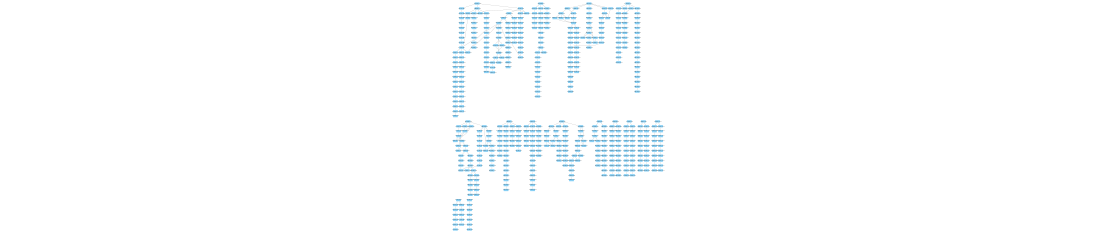

In [232]:
# display main network
p4c.notebook_export_show_image()

## Network
- Each node is a representative sequence of a homologous CDS cluster (min id:0.9 and cov:0.9)
- Each representative sequence (node) has its prokka annotation, defense system prediction and the locus_tag of all cluster members. This information can be accessed through the node table or by clicking on the node in the Cytoscape Client.
- Edges are representations of the a cluster relative topology. Replacing the locus_tags in the genomes with its the respective cluster name and extracting the position of each cluster in relation to its neighbors, it is possible to infer the topology relationships of the clusters. The edge_count parameter can be found in the edges table and displays the number of times a cluster appears next to another in a particular genome.

In [45]:
p4c.delete_visual_style('myStyle')


# NODE_FILL_COLOR = p4c.map_visual_property('node fill color', 'name', 'd', nodes.id.values.tolist(), nodes.node_color.values.tolist())
# p4c.update_style_mapping('myStyle', NODE_FILL_COLOR)

''

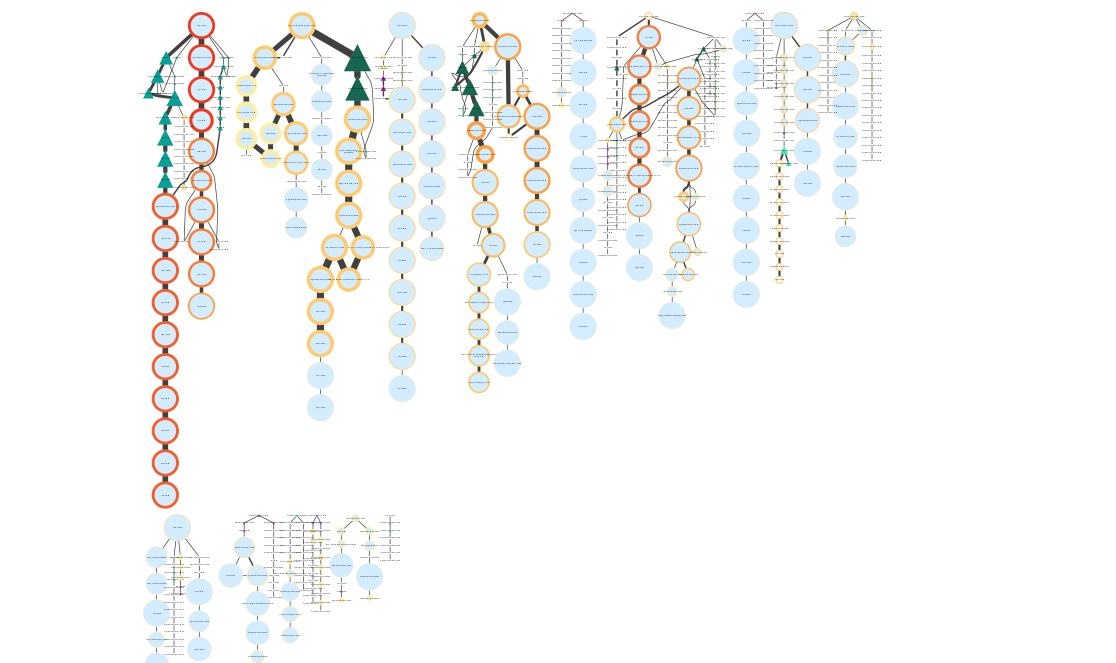

In [233]:
# Create a style 
style_name = "myStyle"

# Set some default values 
# defaults = {'NODE_SHAPE': "ELLIPSE", 'NODE_SIZE': 10, 'NODE_FILL_COLOR' : 'node_color'}
defaults = {'NODE_SHAPE': "ELLIPSE", 'NODE_SIZE': 10, 'NODE_FILL_COLOR': default_color}

# Show labels on the nodes
node_labels = p4c.map_visual_property('node label', 'members_names', 'p') 

# Map node size to the count of members of a seed
node_size_map  = p4c.map_visual_property('NODE_SIZE', 'node_size', 'p')
node_shape_map = p4c.map_visual_property('NODE_SHAPE', 'node_shape', 'p')
node_color_map  = p4c.map_visual_property('node fill color', 'name', 'd', nodes['id'].values.tolist(), nodes.node_color.values.tolist())
edge_size_map  = p4c.map_visual_property('EDGE_WIDTH', 'edge_size', 'p')

node_width = p4c.map_visual_property('NODE_BORDER_WIDTH', 'border_size', 'p')



# Load style
p4c.create_visual_style(style_name, defaults, [
    node_size_map,
    node_labels,
    node_shape_map,
    edge_size_map,
    node_color_map,
    node_width,
])


p4c.set_visual_style(style_name)

p4c.set_node_border_color_mapping(**p4c.gen_node_color_map('diversity_score', p4c.palette_color_brewer_s_YlOrRd(), style_name=style_name))

p4c.notebook_export_show_image()